In [11]:
#Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error

import warnings
from warnings import filterwarnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

In [12]:
data = train = pd.read_csv('./processed_data.csv')

In [13]:
data.head()

,Id,MSSubClass,LotFrontage,LotArea,Street,Alley,LotShape,LandSlope,OverallQual,OverallCond,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,0.730463,2.750250,5.831328,19.212182,0.730463,0.730463,1.540963,0.0,2.440268,1.820334,...,0,0,0,1,0,0,0,0,1,0
1,1.194318,1.820334,6.221214,19.712205,0.730463,0.730463,1.540963,0.0,2.259674,2.440268,...,0,0,0,1,0,0,0,0,1,0
2,1.540963,2.750250,5.914940,20.347241,0.730463,0.730463,0.000000,0.0,2.440268,1.820334,...,0,0,0,1,0,0,0,0,1,0
3,1.820334,2.885846,5.684507,19.691553,0.730463,0.730463,0.000000,0.0,2.440268,1.820334,...,0,0,0,1,1,0,0,0,0,0
4,2.055642,2.750250,6.314735,21.325160,0.730463,0.730463,0.000000,0.0,2.602594,1.820334,...,0,0,0,1,0,0,0,0,1,0


In [14]:
# Data X, Y
X = data.loc[:, data.columns != 'SalePrice' ].values
Y = data.SalePrice.values

In [15]:
#Cross Validation
n_folds = 5

def rmse_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train.values)
    rmse= np.sqrt(-cross_val_score(model, X, Y, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

## Simple Linear Rgression

In [16]:
linear = make_pipeline(RobustScaler(), LinearRegression())
score = rmse_cv(linear)
print("\nLasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


Lasso score: 0.0141 (0.0012)



## Lasso

In [17]:
#lasso model using GridSearchCV
lasso_pipe = Pipeline([("scaler", RobustScaler()),("lasso",Lasso())])

alphas = np.logspace(-3,5, 20)

params = {'lasso__max_iter':[50,100,1000],
          'lasso__alpha':alphas,
          'lasso__normalize':[True, False]}

#Hyper parameter tuning using GridSearchCV
lasso_grid = GridSearchCV(lasso_pipe,
                         params,
                         scoring = 'neg_mean_squared_error',
                         cv=n_folds)


lasso_grid.fit(X,Y)
print (lasso_grid.best_params_)

{'lasso__alpha': 0.001, 'lasso__max_iter': 50, 'lasso__normalize': False}


In [18]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha =lasso_grid.best_params_['lasso__alpha'], max_iter = lasso_grid.best_params_['lasso__max_iter'], normalize = lasso_grid.best_params_['lasso__normalize'], random_state=1))
score = rmse_cv(lasso)
print("\nLasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


Lasso score: 0.0147 (0.0008)



## Ridge

In [20]:
#Ridge model using GridSearchCV
ridge_pipe = Pipeline([("scaler", RobustScaler()),("ridge",Ridge())])


#Hyper parameter tuning using GridSearchCV
params = {'ridge__max_iter':[50,100,1000],
          'ridge__alpha':alphas}

ridge_grid = GridSearchCV(ridge_pipe,
                         params,
                         scoring = 'neg_mean_squared_error',
                         cv=n_folds)


ridge_grid.fit(X,Y)
print (ridge_grid.best_params_)

{'ridge__alpha': 16.23776739188721, 'ridge__max_iter': 50}


In [21]:
ridge = make_pipeline(RobustScaler(), Ridge(alpha =ridge_grid.best_params_['ridge__alpha'], max_iter = ridge_grid.best_params_['ridge__max_iter'], random_state=1))
score = rmse_cv(ridge)
print("\nRidge score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


Ridge score: 0.0130 (0.0008)



## Compare Lasso and Ridge

In [22]:
lasso_scores = []
lasso = Lasso(normalize = True)
#lasso = Lasso(alpha =lasso_grid.best_params_['lasso__alpha'], max_iter = lasso_grid.best_params_['lasso__max_iter'], normalize = lasso_grid.best_params_['lasso__normalize'], random_state=1)
for alpha in alphas:
    lasso.alpha = alpha
    val = np.mean(cross_val_score(lasso, X, Y,scoring="neg_mean_squared_error", cv = n_folds))
    lasso_scores.append(val)

In [23]:
ridge_scores = []
ridge = Ridge(normalize = True)
#ridge = Ridge(alpha =ridge_grid.best_params_['ridge__alpha'], max_iter = ridge_grid.best_params_['ridge__max_iter'], random_state=1)
for alpha in alphas:
    ridge.alpha = alpha
    val = np.mean(cross_val_score(ridge, X, Y,scoring="neg_mean_squared_error", cv = n_folds))
    ridge_scores.append(val)

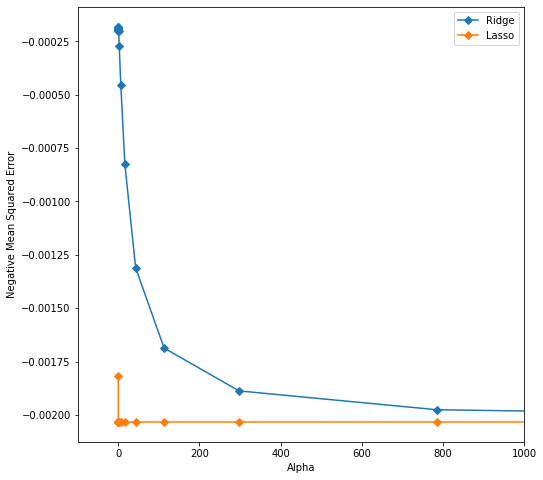

In [26]:
plt.figure(figsize=(8, 8))
plt.plot(alphas, ridge_scores, marker = 'D', label = "Ridge")
plt.plot(alphas, lasso_scores, marker = 'D', label = "Lasso")
plt.legend()
plt.xlim([-100, 1000])
plt.xlabel('Alpha')
plt.ylabel('Negative Mean Squared Error')
plt.show()